In [44]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import xgboost as xg
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope as ho_scope

In [45]:
# Importar la data
data = pd.read_csv('data.csv')

In [46]:
x = data.drop('actual_productivity', axis=1)
y = data['actual_productivity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=127, random_state=10)

### Modelo simple

In [47]:
# Definir el modelo de regresión lineal
model_reg = LinearRegression()

In [48]:
# Los parámetros que el modelo utiliza son

print('Parámetros por defecto del modelo:\n')
print(model_reg.get_params())

Parámetros por defecto del modelo:

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


In [49]:
start = dt.now()
# Ajustar el modelo al conjunto de datos de entrenamiento
model_reg.fit(x_train, y_train)
end = dt.now()

In [50]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

0

In [51]:
# Valores predichos por el modelo
y_pred_train = model_reg.predict(x_train)
y_pred_test = model_reg.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train = mean_absolute_error(y_train, y_pred_train)
error_test = mean_absolute_error(y_test, y_pred_test)

In [52]:
# Se observa al aplicar un modelo xgboost con sus parámetros por defecto
# el MAE para el conjunto de entrenamiento es de 0.105 y en el conjunto de pruebas es de 0.097

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test))

MAE del conjunto de entrenamiento: 0.1047288
MAE del conjunto de prueba: 0.0970348


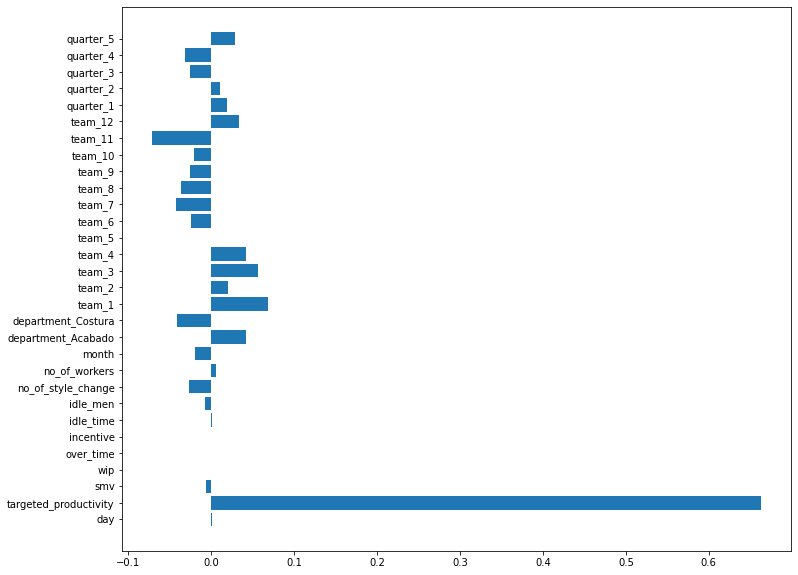

In [53]:
# Importancia de las variables para estimar la productividad

plt.figure(figsize=(12,10))
plt.barh(x_train.columns, model_reg.coef_)
plt.show()

### Modelo con ajuste de hiper parámetros

#### Grid search

In [54]:
# Crear la grilla de parámetros
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [55]:
# Definir el modelo de regresión lineal
model_reg = LinearRegression()

In [56]:
grid_search = GridSearchCV(estimator = model_reg
             , param_grid = param_grid
             , cv = 10
             , n_jobs = -1)

In [57]:
start = dt.now()
grid_search.fit(x_train, y_train)
end = dt.now()

In [58]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

16

In [59]:
grid_search.best_params_

{'fit_intercept': True, 'positive': False}

In [60]:
best_grid = grid_search.best_estimator_

In [61]:
joblib.dump(best_grid, 'resultados/regresion_lineal_grid.pkl')

['resultados/regresion_lineal_grid.pkl']

In [62]:
# Valores predichos por el modelo
y_pred_train_grid = best_grid.predict(x_train)
y_pred_test_grid = best_grid.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
error_test_grid = mean_absolute_error(y_test, y_pred_test_grid)

In [63]:
# Se observa al aplicar un modelo XGBoost con un ajuste de hiper parámetros
# el MAE para el conjunto de entrenamiento es de 0.0421 y en el conjunto de pruebas es de 0.065

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train_grid))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test_grid))

MAE del conjunto de entrenamiento: 0.1047288
MAE del conjunto de prueba: 0.0970348


#### Optimización bayesiana

In [64]:
def optimize(search_space):
    model = LinearRegression(**search_space)
    scores = cross_val_score(model, X=x_train, y=y_train, cv=10, scoring='neg_mean_absolute_error').mean()
    
    return {'loss':scores, 'status': STATUS_OK, 'model': model}

In [65]:
search_space = {
    'fit_intercept': hp.choice('fit_intercept', [True, False])
    ,'positive': hp.choice('positive', [True, False])    
}

optimization_function = partial(
    optimize
)

In [66]:
trials = Trials()
start = dt.now()

result = fmin(
    fn = optimization_function
    , space = search_space
    , max_evals = 50
    , trials=trials
    , algo = tpe.suggest
)

end = dt.now()

100%|██████████| 50/50 [00:11<00:00,  4.55trial/s, best loss: -0.11168767710677852]


In [67]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

11

In [68]:
print(space_eval(search_space, result))

{'fit_intercept': True, 'positive': True}


In [69]:
best_model_bo = trials.best_trial['result']['model']

In [70]:
joblib.dump(best_model_bo, 'resultados/regresion_lineal.pkl')

['resultados/regresion_lineal.pkl']

In [71]:
best_model_bo.fit(x_train, y_train)

LinearRegression(positive=True)

In [72]:
# Valores predichos por el modelo
y_pred_train_bo = best_model_bo.predict(x_train)
y_pred_test_bo = best_model_bo.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train_bo = mean_absolute_error(y_train, y_pred_train_bo)
error_test_bo = mean_absolute_error(y_test, y_pred_test_bo)

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train_bo))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test_bo))

MAE del conjunto de entrenamiento: 0.1085707
MAE del conjunto de prueba: 0.1043032


In [73]:
# trials.losses()

In [74]:
joblib.dump(trials, 'resultados/regresion_lineal_trials.pkl')

['resultados/regresion_lineal_trials.pkl']